<a href="https://colab.research.google.com/github/vidyadhawal/Furniture-Sale-forecasting/blob/master/Furniture_Sale_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
from google.colab import files
uploaded=files.upload()

Saving Superstore.xls to Superstore.xls


In [3]:
df=pd.read_excel('Superstore.xls')

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

There are several categories in the data we start from time series analysis and forecasting for furniture sale

In [4]:
furniture=df.loc[df['Category']=='Furniture']

In [ ]:
furniture['Order Date'].min(),furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

#**Data Preprocessing**
This step includs removing columns we do not need, check missing values,aggregate sales by date and so on

In [ ]:
furniture.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [5]:
cols=['Row ID','Order ID','Ship Date','Ship Mode','Customer ID','Customer Name','Segment','Country','City','State','Postal Code',
      'Region','Product ID','Category','Sub-Category','Product Name','Quantity','Discount','Profit']

In [6]:
furniture.drop(cols,axis=1,inplace=True)

In [7]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [8]:
furniture=furniture.groupby('Order Date')['Sales'].sum().reset_index()

#Indexing with Time Series Data

In [9]:
furniture=furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [10]:
y=furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 furniture sales data.

In [ ]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

#**Visualizing furniture sale time series data**

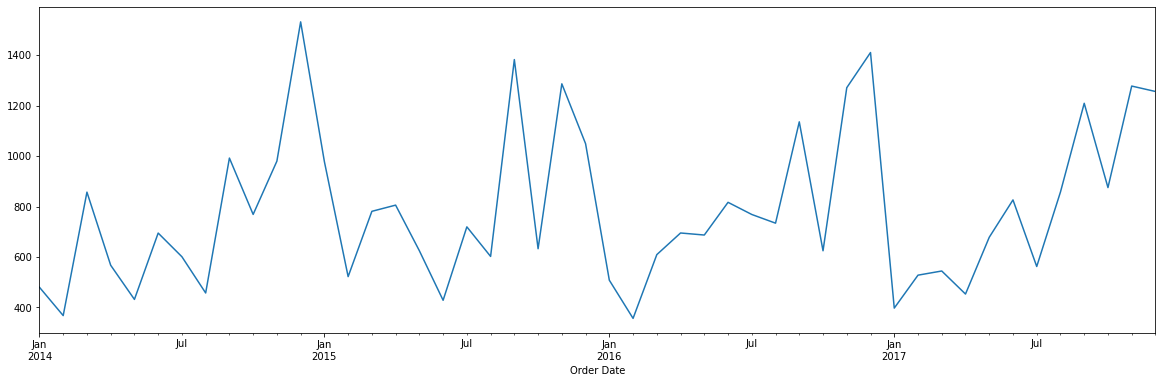

In [ ]:
y.plot(figsize=(20,6))
plt.show()

The time series has seasonality pattern such as sales are always low at the begining of the year and high at the end of the year

we can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend,seasonality,and noise

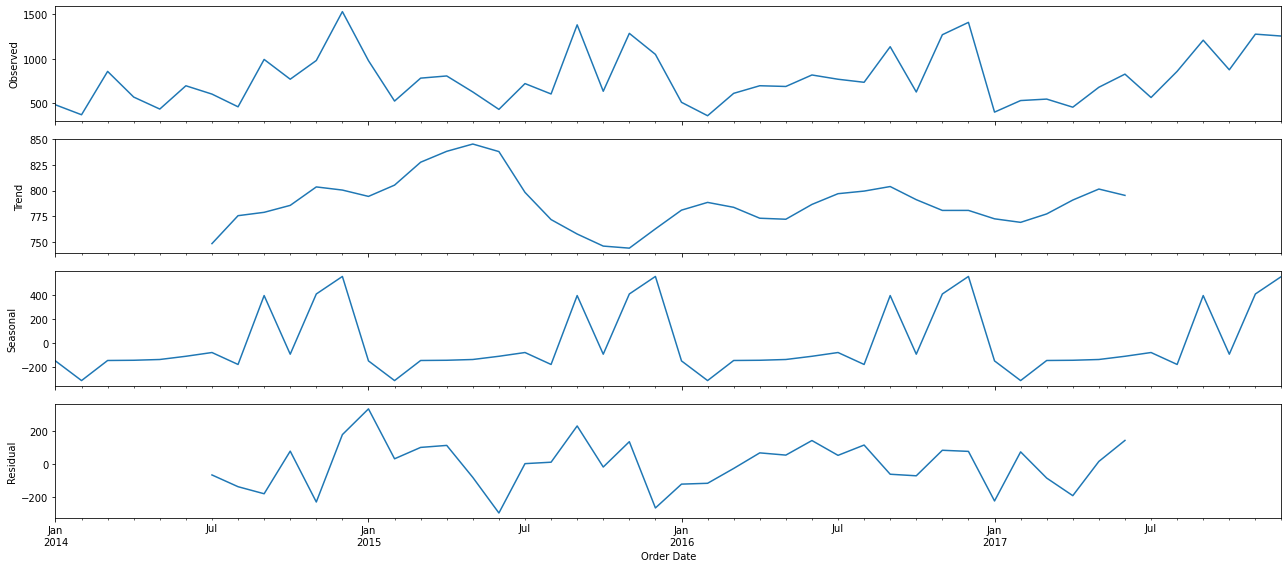

In [11]:

from pylab import rcParams
rcParams['figure.figsize']=18,8

decomposition =sm.tsa.seasonal_decompose(y,model='additive')
fig=decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable,along with its obvious seasonality

#**Time series forecasting with ARIMA**

In [19]:
p = d = q = range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [25]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1478.4829845115771
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1284.058367274109
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758101
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3151.7661575378966
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091676
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.58288234908053
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:354243.3332148463
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946871
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766859465
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1337.3478246551238
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785671879367
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1288.7471922943844
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
AR

The above output shows that SARIMAX(1, 1, 1)x(1, 1, 0, 12)12 yields the lowest  AIC value of 297.78. Therefore we should consider this to be optimal option

#**FItting ARIMA model**

In [26]:
mod=sm.tsa.statespace.SARIMAX(y,order=(1,1,1),seasonal_order=(1,1,0,12),enforce_stationarity=False,enforce_invertibility=False)
results=mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


we should always run model diagnosis to investigate any unusual behavior

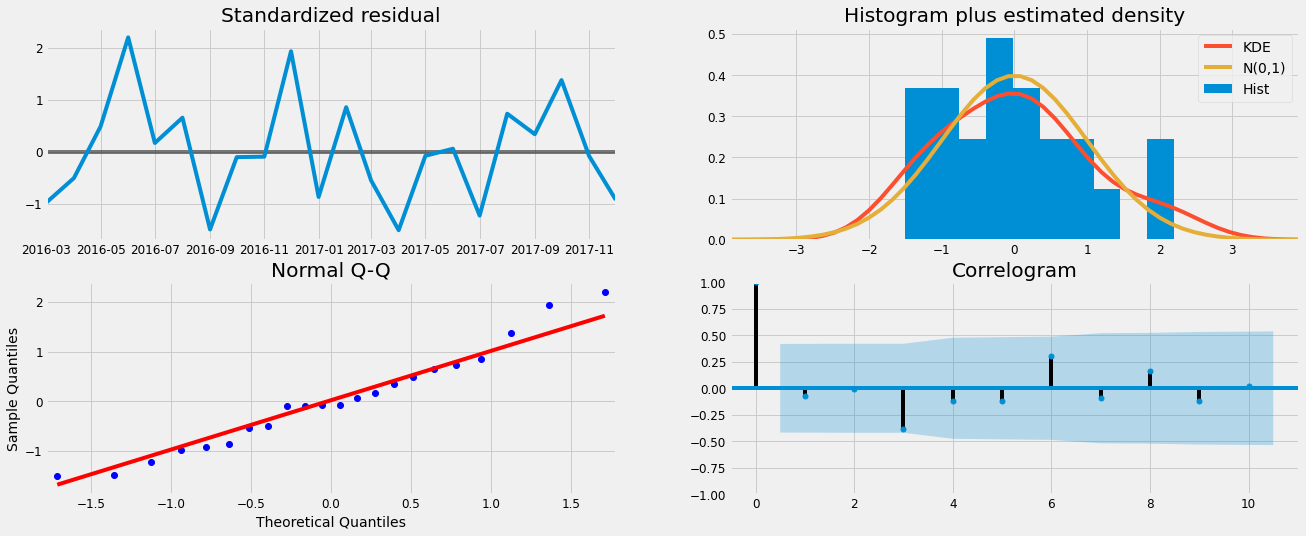

In [29]:
results.plot_diagnostics(figsize=(20,8))
plt.show()

model residuals are near normally distributed

#**Validating Forecast**

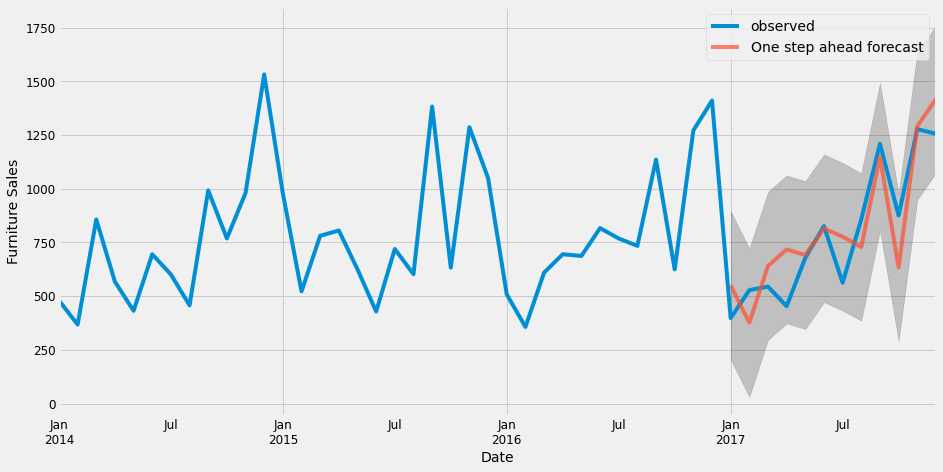

In [30]:
pred=results.get_prediction(start=pd.to_datetime('2017-01-01'),dynamic=False)
pred_ci=pred.conf_int()

ax=y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='One step ahead forecast',alpha=.7,figsize=(14,7))

ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='k',alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

THe line plot is showing the observed values compared to the rolling forecast predictions.Overall our forecasts align with the true values very well, showing an upword trend starts from the begining of the year and captured seasonality toword the end of the year.

In [31]:
y_forecasted=pred.predicted_mean
y_truth=y['2017-01-01':]

mse=((y_forecasted-y_truth)**2).mean()
print('The mean squared error of our forecast is {}'.format(round(mse,2)))

The mean squared error of our forecast is 22993.57


In [32]:
print('Root mean squared error of our forecast is {}'.format(np.sqrt(mse),2))

Root mean squared error of our forecast is 151.63631460835845


#**MSE**
In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

**Root Mean Square Error (RMSE)** tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

#**Producing and visualizing forecast**

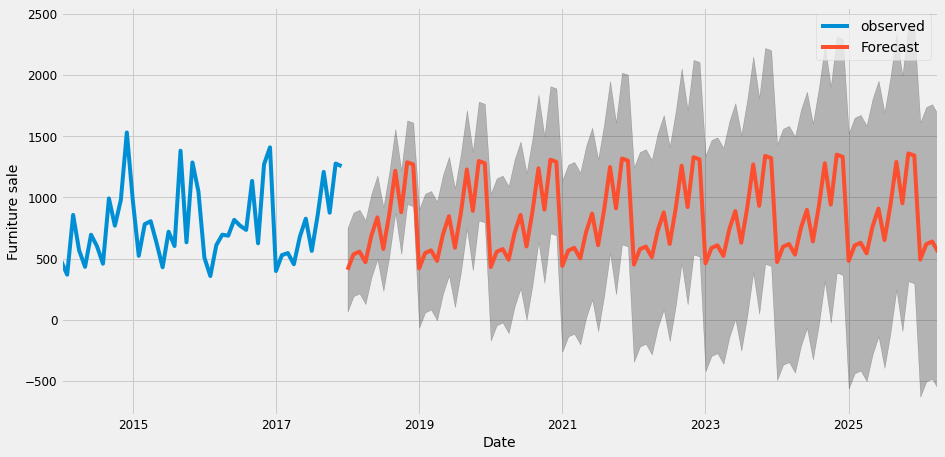

In [33]:
pred_uc=results.get_forecast(steps=100)
pred_ci=pred_uc.conf_int()

ax=y.plot(label='observed',figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture sale')
plt.legend()
plt.show()

Our model clearly captured furniture sale seasonality.As we forecast further out into the firniture, it is natural for us to become less confidant in our values. This is reflected by the confidance interval generated by our model, which grow larger aw we move further out into the future.